# Introduction to Machine Learning: Lab 4


*   Jose Edgar Hernandez Cancino Estrada
*   Marcelo E Jimenez Da Fonseca
*   Mauro Díaz Lupone
*   Alessandro Vecchi

## Imports

In [ ]:
import os
import torch
import shutil
!pip install tensorboardX
import tensorboardX
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Step 1: Import Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt

## Configuration

In [ ]:
# Training
batch_size = 128
n_epochs = 10
n_iters = 600
ngpu = 1
algo = 'dsm'
anneal_power = 2.0
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
evaluate_every = 300
checkpoint_path = 'checkpoints'
checkpoint_every = 250

# Data
image_size = 28
channels = 1

# Model
sigma_begin = 1
sigma_end = 0.01
num_classes = 12
# sigma_begin = 5
# sigma_end = 0.001
batch_norm = False
ngf = 64

# Optimizator
weight_decay = 0.000
optimizer = "Adam"
lr = 0.001
beta1 = 0.9
amsgrad = False

## MNIST Dataset

In [ ]:
# Transformation
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])  # Normalize to [-1, 1] for better training stability
# Download and load training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Download and load test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## Useful objects


*   Train and test Data Loaders
*   Create tensor of $\sigma$ values for the noise conditional score computation



In [ ]:
# Define data loaders for training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4, drop_last=True)
# Create useful test data iterable
test_iterable = iter(test_loader)
input_dim = image_size ** 2 * channels

# Generate sigmas for noise according to configuration
sigmas = torch.tensor(np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))).float().to(device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


##The Score Model
Basic U-Net architecture. Implemented to work with the MNIST dataset.

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.down1 = ConvBlock(in_channels, 64)
        self.down2 = ConvBlock(64, 128)
        self.down3 = ConvBlock(128, 256)
        self.down4 = ConvBlock(256, 512)
        self.bottleneck = ConvBlock(512, 1024)
        self.up4 = ConvBlock(1024 + 512, 512)
        self.up3 = ConvBlock(512 + 256, 256)
        self.up2 = ConvBlock(256 + 128, 128)
        self.up1 = ConvBlock(128 + 64, 64)
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(F.max_pool2d(d1, 2))
        d3 = self.down3(F.max_pool2d(d2, 2))
        d4 = self.down4(F.max_pool2d(d3, 2))
        bn = self.bottleneck(F.max_pool2d(d4, 2))
        target_size = d4.size()[2:]
        up4 = self.up4(torch.cat([F.interpolate(bn, size=target_size, mode='bilinear', align_corners=False), d4], dim=1))
        up3 = self.up3(torch.cat([F.interpolate(up4, size=d3.size()[2:], mode='bilinear', align_corners=False), d3], dim=1))
        up2 = self.up2(torch.cat([F.interpolate(up3, size=d2.size()[2:], mode='bilinear', align_corners=False), d2], dim=1))
        up1 = self.up1(torch.cat([F.interpolate(up2, size=d1.size()[2:], mode='bilinear', align_corners=False), d1], dim=1))
        return self.final(up1)

class ScoreModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(ScoreModel, self).__init__()
        self.unet = UNet(in_channels, out_channels)

    def forward(self, x, sigma):
        return self.unet(x)

## The Loss Function
We attempt to train a score network for a fixed noise parameter $\sigma$.
$\ell(\theta; \sigma) = \frac{1}{2} \mathbb{E}_{p_{\text{data}}(x)} \mathbb{E}_{\tilde{x} \sim N(x, \sigma^2 I)} \left[ \left\| s_\theta(\tilde{x}, \sigma) + \frac{\tilde{x} - x}{\sigma^2} \right\|_2^2 \right]$

In [ ]:
def score_matching_loss(model, x, sigma):
    # Add noise
    perturbed_x = x + torch.randn_like(x) * sigma
    # Compute the true score as specified in the paper
    scores = -(perturbed_x - x)/(sigma**2)
    # Get the predicted scores
    pred_scores = model(perturbed_x, sigma)
    # Reshape to match dimensions
    scores = scores.view(scores.shape[0], -1)
    pred_scores = pred_scores.view(pred_scores.shape[0], -1)
    # Compute the loss
    loss = (1 / 2.) * ((scores - pred_scores) ** 2).sum(dim=-1).mean(dim=0)
    return loss

##Training Procedure

Train the score network to approximate the value of $\nabla_x\log p(x)$.

In [ ]:
def train_model(score_model, sigma, verbose=False, patience=6):
    optimizer = torch.optim.Adam(score_model.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, 0.999), amsgrad=amsgrad)
    losses = []
    step = 0
    best_loss = float('inf')  # Initialize with a large number for comparison
    patience_counter = 0  # Counter for early stopping

    print('Training score model for sigma', sigma.item())
    for epoch in range(n_epochs):
        print("Epoch: {}".format(epoch))
        for i, (X, y) in enumerate(train_loader):
            step += 1
            score_model.train()

            X = X.to(device)
            X = X / 256. * 255. + torch.rand_like (X) / 256. #### <-----

            loss = score_matching_loss(score_model, X, sigma)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if verbose:
                print("step: {}, loss: {}".format(step, loss.item()))
            losses.append(loss.item())

            if step >= n_iters:
                return losses

            if step % evaluate_every == 0:
                score_model.eval()
                try:
                    test_X, test_y = next(test_iterable)
                except StopIteration:
                    test_iter = iter(test_loader)
                    test_X, test_y = next(test_iterable)

                test_X = test_X.to(device)
                test_X = test_X / 256. * 255. + torch.rand_like(test_X) / 256.

                with torch.no_grad():
                    test_dsm_loss = score_matching_loss(score_model, test_X, sigma)

                if verbose:
                    print(f'Evaluation at step {step}. Test loss =', test_dsm_loss)

                # Early stopping condition
                if test_dsm_loss < best_loss:
                    best_loss = test_dsm_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at step {step} due to no improvement in validation loss for {patience} evaluations.")
                        return losses

            if step % checkpoint_every == 0:
                states = [
                    score_model.state_dict(),
                    optimizer.state_dict(),
                ]
                os.makedirs(checkpoint_path, exist_ok=True)
                torch.save(states, os.path.join(checkpoint_path, 'checkpoint_{}.pth'.format(step)))
                torch.save(states, os.path.join(checkpoint_path, 'checkpoint.pth'))

    return losses

In [ ]:
models = dict()
losses = dict()
for sigma in sigmas:
  # Initialize the model
  models[sigma] = ScoreModel(in_channels=1, out_channels=1).to(device)
  # Start Training
  losses[sigma] = train_model(models[sigma], sigma)

Training score model for sigma 1.0
Epoch: 0
Training score model for sigma 0.657933235168457
Epoch: 0
Training score model for sigma 0.4328761398792267
Epoch: 0
Training score model for sigma 0.2848035991191864
Epoch: 0
Training score model for sigma 0.18738174438476562
Epoch: 0
Training score model for sigma 0.12328467518091202
Epoch: 0
Training score model for sigma 0.08111308515071869
Epoch: 0
Training score model for sigma 0.05336699262261391
Epoch: 0
Training score model for sigma 0.0351119190454483
Epoch: 0
Training score model for sigma 0.02310129627585411
Epoch: 0
Training score model for sigma 0.015199110843241215
Epoch: 0
Training score model for sigma 0.009999999776482582
Epoch: 0


#### Save models

In [ ]:
import os
import torch
from google.colab import files

# Save the model files
checkpoint_path = '/content/checkpoints'
for name, model in models.items():
    # Save the model
    model_path = os.path.join(checkpoint_path, f'model{name}.pth')
    os.makedirs(checkpoint_path, exist_ok=True)

    torch.save(model.state_dict(), model_path)

# Save the lists to separate files
save_dir = '/content/saved_lists/'
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

# Save each list to a separate file
for key, value in losses.items():
    file_path = os.path.join(save_dir, f'{key}.txt')
    with open(file_path, 'w') as f:
        for item in value:
            f.write(f"{item}\n")  # Writing each list item on a new line

# Create a zip archive of all the files to make it easier to download them
import shutil

# Create a zip file containing all saved models and lists
shutil.make_archive('/content/models', 'zip', '/content', 'checkpoints')
shutil.make_archive('/content/lists', 'zip', '/content', 'saved_lists')

# Now, download the zip file containing all the models and lists
files.download('/content/models.zip')
files.download('/content/lists.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Read models

In [ ]:
# Read models
checkpoint_path = '/content/checkpoints'
models = dict()
for sigma in sigmas:
  model_path = os.path.join(checkpoint_path, f'model{sigma}.pth')
  model = ScoreModel(in_channels=1, out_channels=1).to(device)
  model.load_state_dict(torch.load(model_path))
  models[sigma] = model
  model.eval()
  print(f'Loaded model for sigma {sigma}')

# Read losses
save_dir = '/content/saved_lists/'
losses = dict()
for sigma in sigmas:
  file_path = os.path.join(save_dir, f'{sigma}.txt')
  with open(file_path, 'r') as f:
      losses[sigma] = [float(line.strip()) for line in f]
  print(f'Loaded losses for sigma {sigma}')
  print(f'Number of losses for sigma {sigma}: {len(losses[sigma])}')

<ipython-input-27-96662bd1b6a6>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loaded model for sigma 1.0
Loaded model for sigma 0.657933235168457
Loaded model for sigma 0.4328761398792267
Loaded model for sigma 0.2848035991191864
Loaded model for sigma 0.18738174438476562
Loaded model for sigma 0.12328467518091202
Loaded model for sigma 0.08111308515071869
Loaded model for sigma 0.05336699262261391
Loaded model for sigma 0.0351119190454483
Loaded model for sigma 0.02310129627585411
Loaded model for sigma 0.015199110843241215
Loaded model for sigma 0.009999999776482582
Loaded losses for sigma 1.0
Number of losses for sigma 1.0: 600
Loaded losses for sigma 0.657933235168457
Number of losses for sigma 0.657933235168457: 600
Loaded losses for sigma 0.4328761398792267
Number of losses for sigma 0.4328761398792267: 600
Loaded losses for sigma 0.2848035991191864
Number of losses for sigma 0.2848035991191864: 600
Loaded losses for sigma 0.18738174438476562
Number of losses for sigma 0.18738174438476562: 600
Loaded losses for sigma 0.12328467518091202
Number of losses fo

###Reporting Loss Convergence
- Optimization Loss Curve: Plot the loss during training.


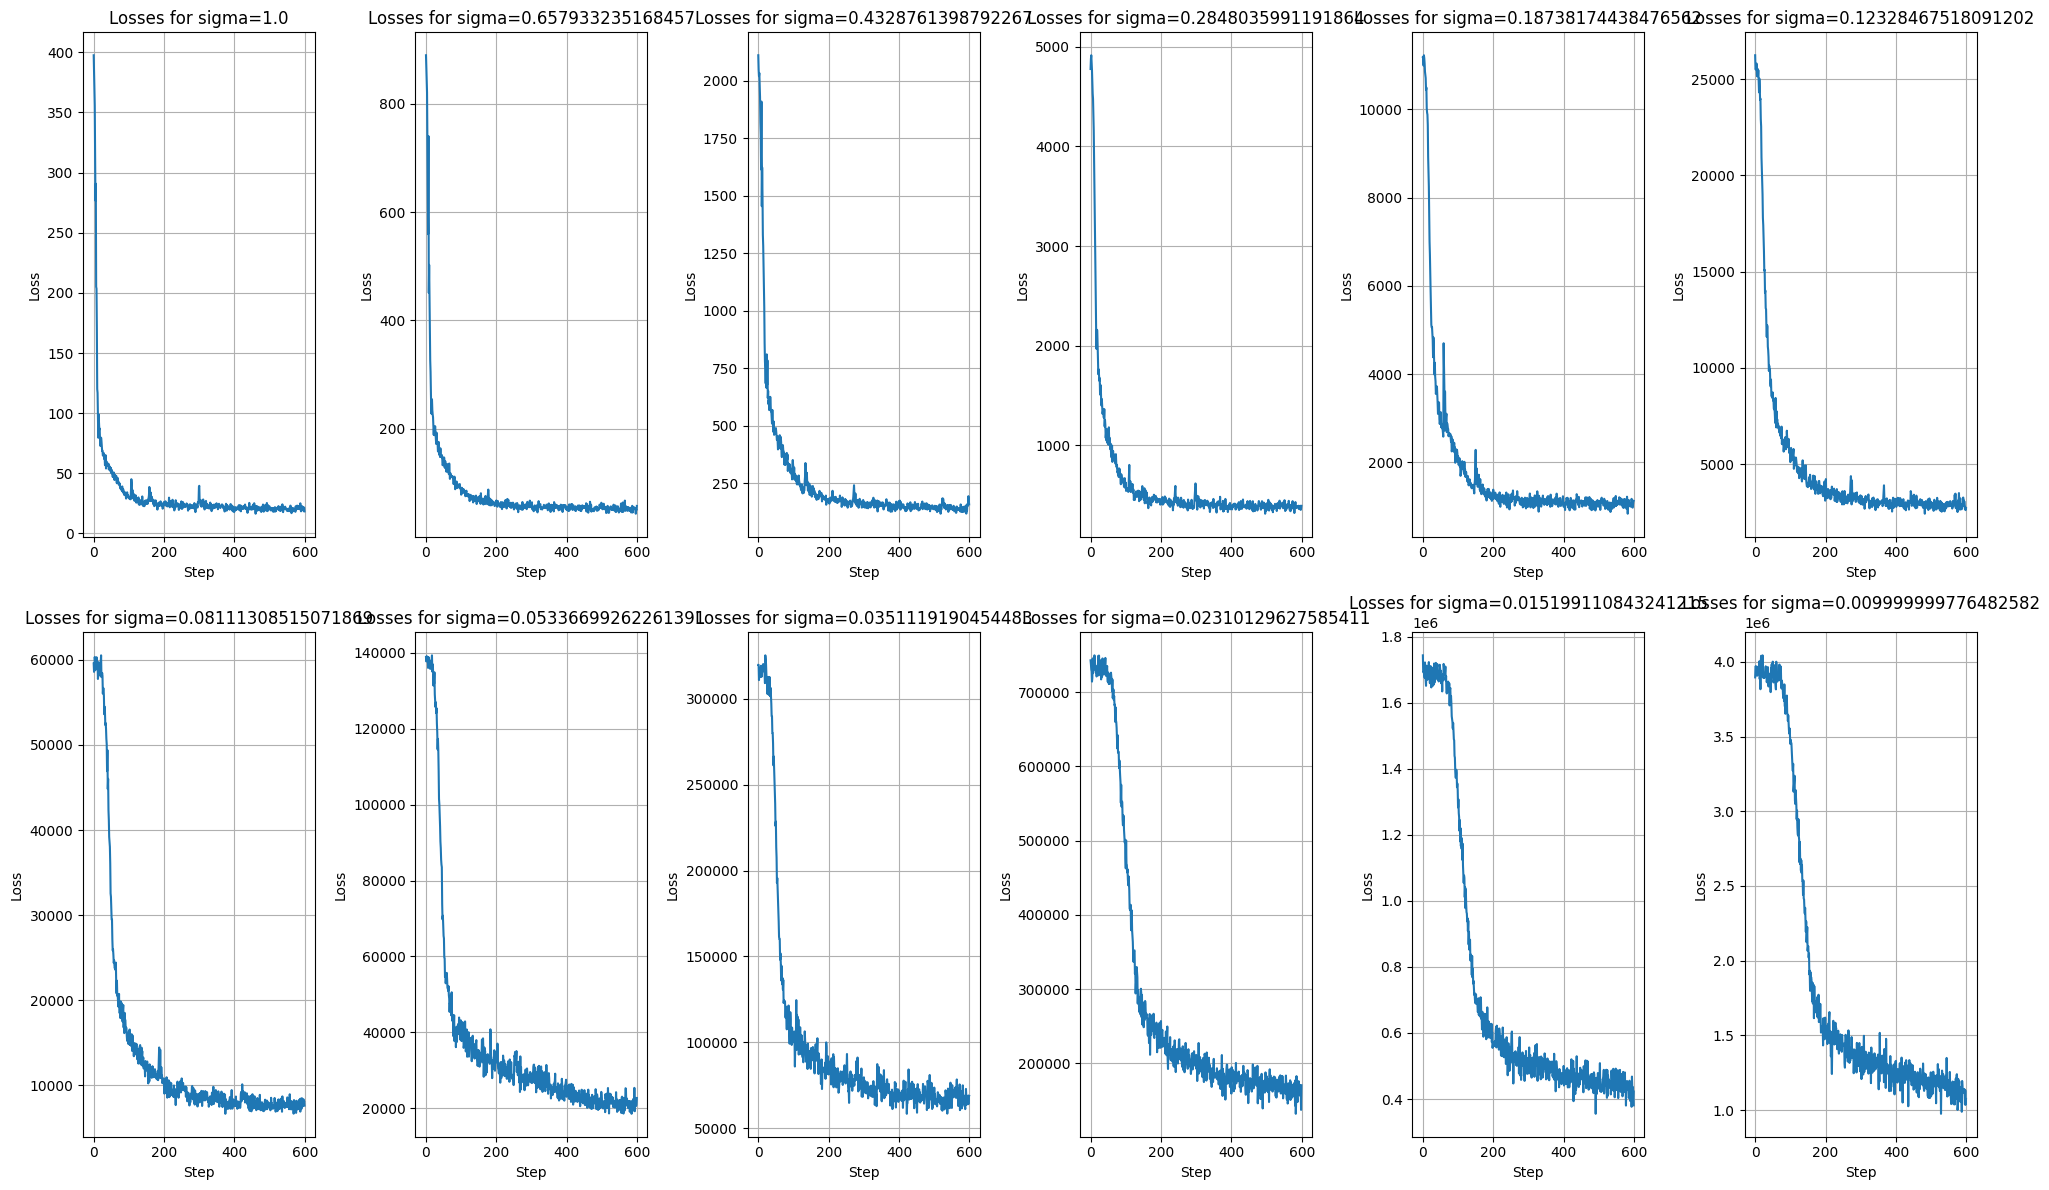

In [ ]:
n_sigma = len(losses)
n_cols = (n_sigma + 1) // 2
fig, axes = plt.subplots(2, n_cols, figsize=(20, 6 * 2))
axes = axes.flatten()


for i, (sigma, loss_values) in enumerate(losses.items()):
    # axes[i].plot(loss_values)
    axes[i].plot(range(len(loss_values)), loss_values, label=f'sigma={sigma}')
    axes[i].set_title(f"Losses for sigma={sigma}")
    axes[i].set_xlabel("Step")
    axes[i].set_ylabel("Loss")
    axes[i].grid(True)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## NCSN inference via annealed Langevin dynamics
- Sampling via Annealed Langevin Dynamics
- Initialize with Gaussian noise.
- Update using Langevin dynamics for T=100 steps per noise level.
- Repeat for each noise level in descending order.

In [ ]:
def langevin_sampling(models, sigmas, T=100, epsilon=2e-5):
    # Initialize ~X
    x = torch.randn((32, 1, 28, 28)).to(device) * sigmas[0].item()

    for sigma in models.keys():
        model = models[sigma]
        model.eval()
        sigma = sigma.item()
        step_size = epsilon * sigma**2 / sigmas[-1]**2
        # print(f'Step sigma {sigma}')
        for t in range(T):
            torch.cuda.empty_cache()
            # print(t, end=" ")
            z = torch.randn_like(x)
            with torch.no_grad():
              score = model(x, sigma)
            x = x + step_size/2.0 * score + (step_size)**0.5 * z
        # print()
    return x


## Results visualization

#Observations and discussion:

After running the experiments, we can conclude that the results are acceptable based on the objectives and constraints of this homework. Although we were not able to retrieve a legible picture of handwritten numbers, the model was able to successfully learn to approximate the score functions for the different noise levels. The best results were found using the stardard 1 to 0.01 noise levels, and the loss functions demonstrated good convergence for the various values of $\sigma$.

## Key Observations:

1. **Loss Convergence:**
   - We observed that the losses showed consistent improvement for the different $\sigma$ values.d
   - In particular, we noticed that for 600 iterations the losses converged to their minimun value, given the simplified model that we used.

2. **Effect of Different $\sigma$ Values:**
   - As we experimented with sigma values ranging from 1 to 0.01 and 5 to 0.001, we found that using the first configuration of $\sigma$ values led to better results.
  - The performance improvement was noticeable in the choice of the number of channels. Initially, we chose **4 channels**, which led to poor results (shown in the previous attempts cell).
  - Later, we experimented with **8** and **10 channels**, which resulted in a better and more distinguishable generation of images.


3. **Challenges and Limitations:**
   - It is important to acknowledge that due to computational limitations and time constraints, we were unable to fully fine-tune the model’s parameters.
   - Also the Score Model that we used was a standard U-Net, without the instance normalization method and the diluted convolutions that were used in the paper. That probably explains why the generation of images were not ideal even with a good result of our loss function.
   - Therefore, while results are promising, further improvements are expected with more time and computational resources


## Future Work:

To achieve better results, we would focus on implementing a more complex Score Model, that includes the instance normalization method and the diluted convolutions. Additionally, it would be beneficial to explore the Score-Based Generative Modeling through Stochastic Differential Equations, that is the improved implementation of this same model published by the same author in 2021

---

## Conclusion Summary:

In summary, the results from our experiments with the score matching approach are acceptable. While the training process showed adequate convergence, a more complex Score Model is needed. With more time and/or computational resources, we could achieve better results.


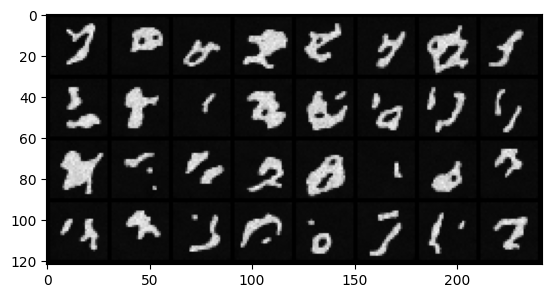

In [ ]:
import torchvision
generated_images = langevin_sampling(models, sigmas)
grid = torchvision.utils.make_grid(generated_images, nrow=8, normalize=True)

# Move the grid tensor to the CPU before converting it to a NumPy array
grid_cpu = grid.cpu()

plt.imshow(grid_cpu.permute(1, 2, 0))
plt.show()

### Previous attempts

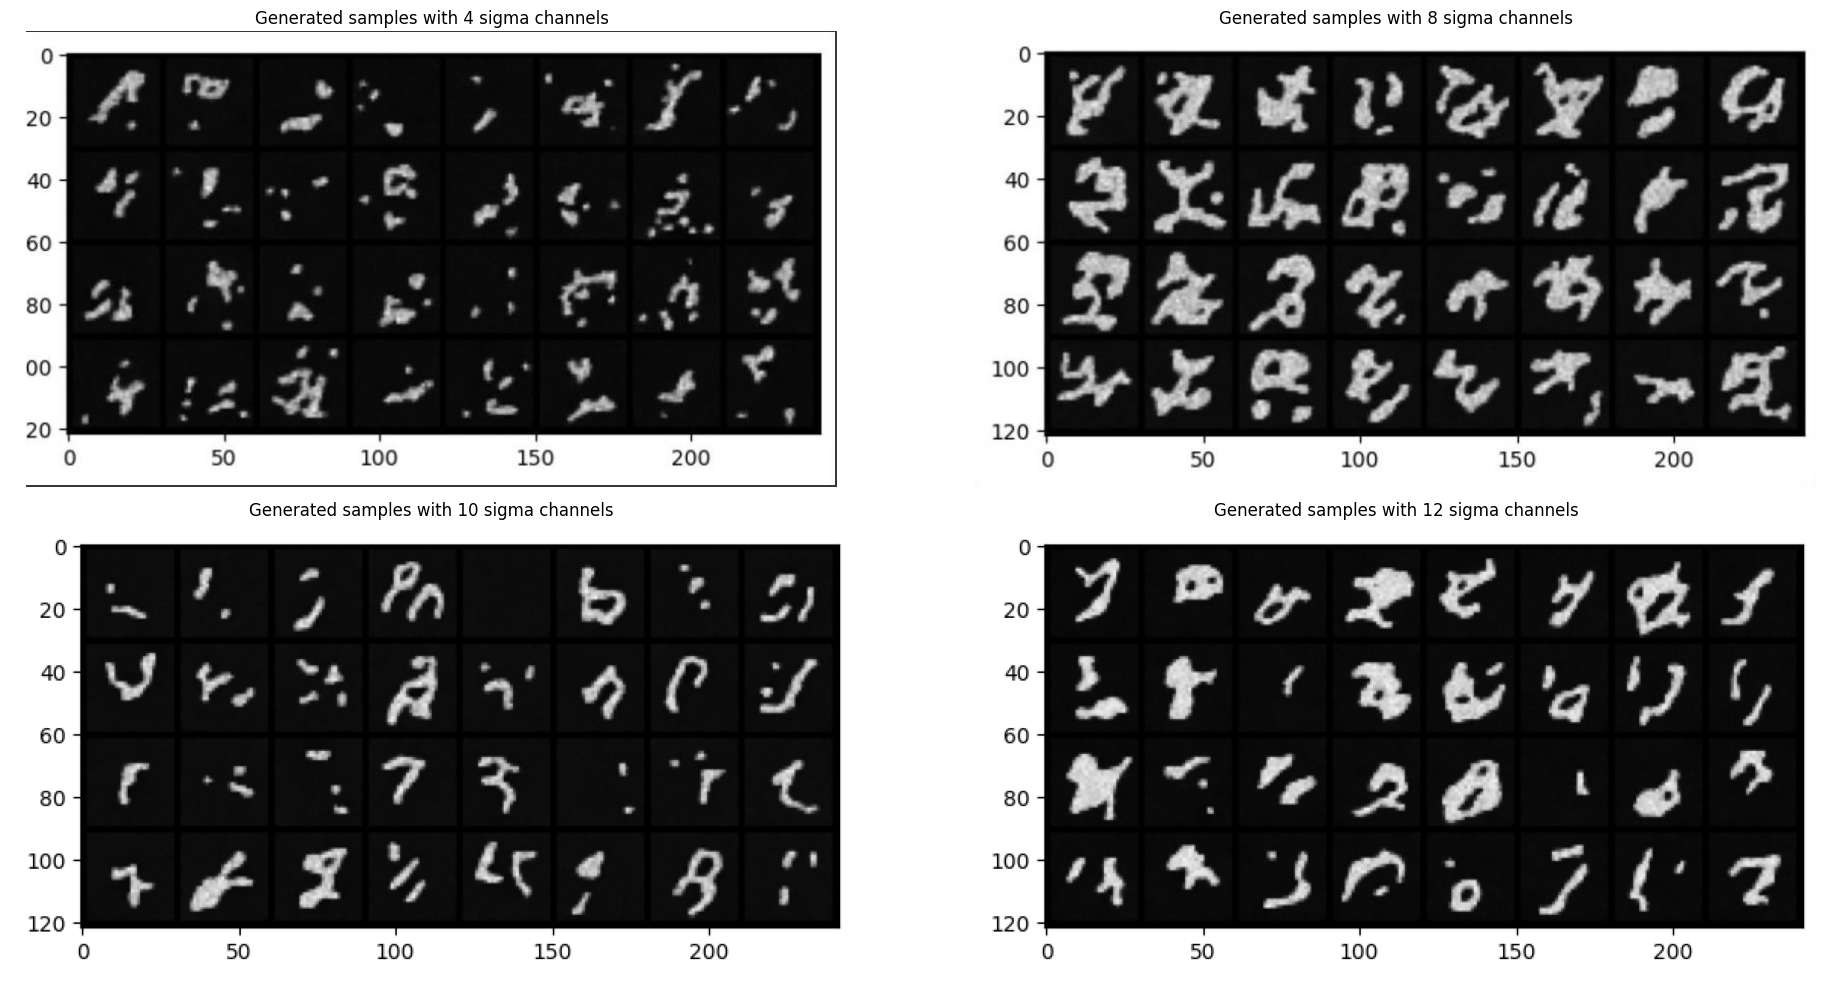

In [ ]:
import matplotlib.image as mpimg
image1 = mpimg.imread("uno.jpg")
image2 = mpimg.imread("dos.jpg")
image3 = mpimg.imread("tres.png")
image4 = mpimg.imread("cuatro.png")
fig, axes = plt.subplots(2, 2, figsize=(20, 10))  # 1 row, 2 columns

# Call imshow on the individual axes objects, not the axes array
axes[0, 0].imshow(image1)  # Access the top-left axes using [0, 0]
axes[0, 0].set_title("Generated samples with 4 sigma channels")
axes[0, 0].axis('off')

axes[0, 1].imshow(image2)  # Access the top-right axes using [0, 1]
axes[0, 1].set_title("Generated samples with 8 sigma channels")
axes[0, 1].axis('off')

axes[1, 0].imshow(image3)  # Access the bottom-left axes using [1, 0]
axes[1, 0].set_title("Generated samples with 10 sigma channels")
axes[1, 0].axis('off')

axes[1, 1].imshow(image4)  # Access the bottom-right axes using [1, 1]
axes[1, 1].set_title("Generated samples with 12 sigma channels")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

### Honorable mention: Nice results!

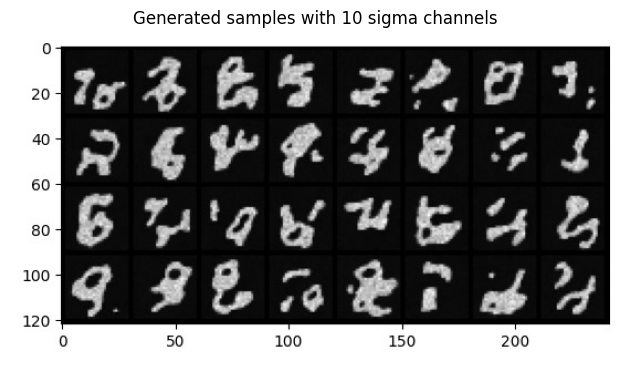

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
image1 = mpimg.imread("resultado.jpeg")
fig = plt.figure()
plt.imshow(image1)
plt.title("Generated samples with 10 sigma channels")
plt.axis('off')
plt.tight_layout()
plt.show()